# Transformer Model Method


## Setup the Libraries

In [ ]:
!nvidia-smi

Thu Aug 20 18:07:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%bash
pip3 install torch
pip3 install nltk
pip3 install transformers
pip3 install tokenizers
#pip3 install tqdm
#pip3 install pandas
#pip3 install matplotlib

  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=701aa720b0e4b4aaca935e39c7df8ea632cecb5b33295ef17f5b7702fbc8f377
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import nltk
nltk.download('popular')
nltk.download('stopwords')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import RobertaTokenizerFast, RobertaModel
from tokenizers import ByteLevelBPETokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os
import joblib

## Change Path and Import Dataframe 


In [ ]:
## mount the drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cwd = os.getcwd()
os.chdir('/content/drive/My Drive/Colab Notebooks/janataHackIndependenceDay')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0


In [ ]:
print(train.columns)
print(train.shape)

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')
(20972, 9)


In [ ]:
classes = list(train.drop(columns=['ID','TITLE','ABSTRACT']).columns)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Data Pre-Processing


In [ ]:
stopwords = list(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(x):
  x = str(x).lower()
  x = re.sub('\n', ' ', x)
  x = x.split()
  x = [i for i in x if i not in stopwords]
  x = [lemmatizer.lemmatize(i) for i in x]
  x = ' '.join(x)
  x = re.sub('\&', ' and ', x)
  x = re.sub('\/', ' or ', x)
  x = re.sub('\s+', ' ', x)
  x = str(x).strip()
  return x

In [ ]:
train['TITLE'] = train['TITLE'].apply(preprocess)
train['ABSTRACT'] = train['ABSTRACT'].apply(preprocess)
train['text'] = train['TITLE'] + train['ABSTRACT']

In [ ]:
test['TITLE'] = test['TITLE'].apply(preprocess)
test['ABSTRACT'] = test['ABSTRACT'].apply(preprocess)
test['text'] = test['TITLE'] + test['ABSTRACT']

In [ ]:
X = train['text'].tolist()
Y = torch.tensor(train[classes].values)
Y.shape

torch.Size([20972, 6])

In [ ]:
X_test = test['text'].tolist()
X_test[4]

'witness-functions versus interpretation-functions secrecy cryptographic protocols: choose?proving cryptographic protocol correct secrecy hard task. one strongest strategy reach goal show increasing, mean security level every single atomic message exchanged protocol, safely evaluated, never deceases. recently, two family function proposed measure security level atomic messages. first one family interpretation-functions. second family witness-functions. paper, show witness-functions efficient interpretation-functions. give detailed analysis ad-hoc protocol witness-functions succeed proving correctness secrecy interpretation-functions fail so.'

## Training

In [ ]:
train_tokenizer = False

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base',
                                                   do_lower_case=True,
                                                   add_special_token=True,
                                                   max_length=256,
                                                   pad_to_max_length=True)

In [ ]:
language_model = RobertaModel.from_pretrained('roberta-base')

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, classes, hidden_layer, tokenizer, model):
        super().__init__()
        self.input_dim = input_dim
        self.classes = classes
        self.hidden_layer = hidden_layer

        self.tokenizer = tokenizer
        self.model = model

        self.fc1 = nn.Linear(self.input_dim, self.hidden_layer)
        self.relu = nn.ReLU()

        self.cs = nn.Linear(self.hidden_layer, 1)
        self.phy = nn.Linear(self.hidden_layer, 1)      
        self.math = nn.Linear(self.hidden_layer, 1)      
        self.stat = nn.Linear(self.hidden_layer, 1)      
        self.qb = nn.Linear(self.hidden_layer, 1)      
        self.qa = nn.Linear(self.hidden_layer, 1)      

    
    def language_model(self, x):
      encoding = self.tokenizer.batch_encode_plus(x, add_special_tokens=True,
                                                  truncation=True,
                                                  padding=True,
                                                  return_tensors='pt')
      input_ids = encoding['input_ids'].to(device)
      attention_mask = encoding['attention_mask'].to(device)
      del encoding
      x = self.model(input_ids, attention_mask)[1]
      del input_ids
      del attention_mask
      return x

    def forward(self, x):
      x = self.language_model(x)
      x = self.relu(self.fc1(x))

      result = [self.cs(x).cpu(),
      self.phy(x).cpu(),
      self.math(x).cpu(),
      self.stat(x).cpu(),
      self.qb(x).cpu(),
      self.qa(x).cpu()]

      return dict(zip(self.classes, result))


    def get_loss(self, net_output, ground_truth, criterion):
      cs_loss = criterion(net_output['Computer Science'], ground_truth[:,0].view(-1,1)).cpu()
      phy_loss = criterion(net_output['Physics'], ground_truth[:,1].view(-1,1)).cpu()
      math_loss = criterion(net_output['Mathematics'], ground_truth[:,2].view(-1,1)).cpu()
      stat_loss = criterion(net_output['Statistics'], ground_truth[:,3].view(-1,1)).cpu()
      qb_loss = criterion(net_output['Quantitative Biology'], ground_truth[:,4].view(-1,1)).cpu()
      qa_loss = criterion(net_output['Quantitative Finance'], ground_truth[:,5].view(-1,1)).cpu()

      loss_list = [cs_loss, phy_loss, math_loss, stat_loss, qb_loss, qa_loss]

      loss = np.sum(loss_list)
      
      return loss#, dict(zip(self.classes, loss_list))

In [ ]:
model = Net(768, classes, 512, tokenizer, language_model).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [ ]:
EPOCHS = 4
mini_batch = 16
loss = []
for epoch in range(EPOCHS):
  for chunk in tqdm(range(0, len(X), mini_batch)):
    x = X[chunk:chunk+mini_batch]
    y = Y[chunk:chunk+mini_batch,].float()
    optimizer.zero_grad()
    output = model(x)
    loss_train = model.get_loss(output, y, criterion)
    loss_train.backward()
    if chunk%128 == 0:
      loss.append(loss_train)
    optimizer.step()
  path = "liteModel" 
  path2 = "liteModelPickle"
torch.save(model.state_dict(), path)
pickle.dump(model, open(path2, 'wb'))

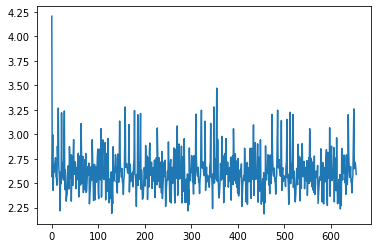

In [ ]:
plt.plot(loss)

In [ ]:
'''EPOCHS = 16
mini_batch = 16
loss = []
for epoch in range(EPOCHS):
  for chunk in tqdm(range(0, len(X), mini_batch)):
    x = X[chunk:chunk+mini_batch]
    y = Y[chunk:chunk+mini_batch,].float()
    optimizer.zero_grad()
    output = model(x)
    loss_train = model.get_loss(output, y, criterion)
    loss_train.backward()
    if chunk%128 == 0:
      loss.append(loss_train)
    optimizer.step()
  path = "model.pth" 
  pickle.dump(model, open(path, 'wb'))'''

100%|██████████| 1311/1311 [18:57<00:00,  1.15it/s]


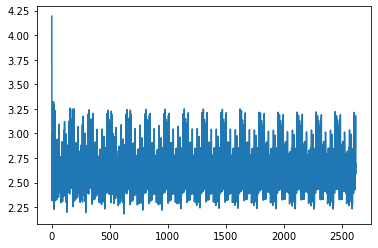

In [ ]:
plt.plot(loss)

In [ ]:
torch.save(model, "fullModel")

## Testing and Validation


In [ ]:
os.listdir()

['test.csv',
 'train.csv',
 'sample_submission.csv',
 'model.pth',
 'liteModel',
 'liteModelPickle']

In [ ]:
model = Net(768, classes, 512, tokenizer, language_model).to(device)
model.load_state_dict(torch.load("liteModel"))

<All keys matched successfully>

In [ ]:
model.eval()

In [ ]:
([X_test[4]])

['witness-functions versus interpretation-functions secrecy cryptographic protocols: choose?proving cryptographic protocol correct secrecy hard task. one strongest strategy reach goal show increasing, mean security level every single atomic message exchanged protocol, safely evaluated, never deceases. recently, two family function proposed measure security level atomic messages. first one family interpretation-functions. second family witness-functions. paper, show witness-functions efficient interpretation-functions. give detailed analysis ad-hoc protocol witness-functions succeed proving correctness secrecy interpretation-functions fail so.']

In [ ]:
outputs = model([X_test[4]])

In [ ]:
outputs.keys()

dict_keys(['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance'])

In [ ]:
torch.sigmoid(outputs['Quantitative Finance'])

tensor([[0.0110]], grad_fn=<SigmoidBackward>)

In [ ]:
_, predicted = torch.max(outputs, 1)
predicted

TypeError: ignored

# Lib Short Text Method

## Library Imports


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import tqdm as tqdm

## Data Pre-Processing


In [ ]:
cwd = os.getcwd()
os.chdir('/content/drive/My Drive/Colab Notebooks/janataHackIndependenceDay')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
test

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...
...,...,...,...
8984,29957,Supporting mixed-datatype matrix multiplicatio...,We approach the problem of implementing mixe...
8985,29958,An axiomatic basis for Blackwell optimality,In the theory of Markov decision processes (...
8986,29959,GeneVis - An interactive visualization tool fo...,GeneVis is a web-based tool to visualize com...
8987,29960,Quantifying the causal effect of speed cameras...,This paper quantifies the effect of speed ca...


In [ ]:
colsss=train.columns.to_list()
colsss.remove('ID')
colsss.remove('TITLE')
colsss.remove('ABSTRACT')

for i in colsss:
  libShort=train.copy()
  dropper=train.columns.to_list()
  dropper.remove('ID')
  dropper.remove('TITLE')
  dropper.remove('ABSTRACT')
  dropper.remove(str(i))
  libShort['text'] = libShort['TITLE']+libShort['ABSTRACT']
  libShort = libShort.drop(columns=dropper)
  libShort = libShort.drop(columns=['ID','TITLE','ABSTRACT'])
  cols = libShort.columns.tolist()
  cols = cols[-1:] + cols[:-1]
  libShort = libShort[cols]
  filename=str(i)+'.csv'
  libShort.to_csv(filename,sep='\t',header=False,index=False)

In [ ]:
dps@1234

In [ ]:
libShort=test.copy()
libShort['text'] = libShort['TITLE']+libShort['ABSTRACT']
libShort = libShort.drop(columns=['ID','TITLE','ABSTRACT'])
libShort['label'] = 0
cols = libShort.columns.tolist()
cols = cols[-1:] + cols[:-1]
libShort = libShort[cols]
filename='newtest.csv'
libShort.to_csv(filename,sep='\t',header=False,index=False)

In [ ]:
libShort

,label,text
0,0,Closed-form Marginal Likelihood in Gamma-Poiss...
1,0,Laboratory mid-IR spectra of equilibrated and ...
2,0,Case For Static AMSDU Aggregation in WLANs Fr...
3,0,The $Gaia$-ESO Survey: the inner disk intermed...
4,0,Witness-Functions versus Interpretation-Functi...
...,...,...
8984,0,Supporting mixed-datatype matrix multiplicatio...
8985,0,An axiomatic basis for Blackwell optimality I...
8986,0,GeneVis - An interactive visualization tool fo...
8987,0,Quantifying the causal effect of speed cameras...


# CNN Based Approach


## Setup the Libraries

In [ ]:
!nvidia-smi

Sun Aug 23 12:40:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%bash
pip3 install torch
pip3 install nltk
pip3 install transformers
pip3 install tokenizers
#pip3 install tqdm
#pip3 install pandas
#pip3 install matplotlib

In [ ]:
import nltk
nltk.download('popular')
nltk.download('stopwords')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import RobertaTokenizerFast, RobertaModel
from tokenizers import ByteLevelBPETokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os
import joblib

## Change Path and Import Dataframe 


In [ ]:
## mount the drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cwd = os.getcwd()
os.chdir('/content/drive/My Drive/Colab Notebooks/janataHackIndependenceDay')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0


In [ ]:
print(train.columns)
print(train.shape)

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')
(20972, 9)


In [ ]:
classes = list(train.drop(columns=['ID','TITLE','ABSTRACT']).columns)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Data Pre-Processing


In [ ]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
stopwords = list(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer()

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
#from gensim.parsing.porter import PorterStemmer
#porter_stemmer = PorterStemmer()
separator = ' '
def preprocess(x):
  #x = remove_stopwords(x)
  #x = simple_preprocess(x, deacc=True)
  x = separator.join(x)
  x = str(x).lower()
  x = re.sub('\n', ' ', x)
  x = x.split()
  x = [i for i in x if i not in stopwords]
  x = [lemmatizer.lemmatize(i) for i in x]
  x1= []
  for word in x:
      try:
          x1.append(CONTRACTION_MAP[word])
      except:
          x1.append(word)
  x = ' '.join(x1)
  x = re.sub('\&', ' and ', x)
  x = re.sub('\/', ' or ', x)
  x = re.sub('\s+', ' ', x)
  x = str(x).strip()
  return x

In [ ]:
train['TITLE'] = train['TITLE'].apply(preprocess)
train['ABSTRACT'] = train['ABSTRACT'].apply(preprocess)
train['text'] = train['TITLE'] + train['ABSTRACT']

In [ ]:
train['text'].head()

0    reconstructing subject specific effect mappred...
1    rotation invariance neural networkrotation inv...
2    spherical polyharmonics poisson kernel polyhar...
3    finite element approximation stochastic maxwel...
4    comparative study discrete wavelet transforms ...
Name: text, dtype: object

In [ ]:
test['TITLE'] = test['TITLE'].apply(preprocess)
test['ABSTRACT'] = test['ABSTRACT'].apply(preprocess)
test['text'] = test['TITLE'] + test['ABSTRACT']

In [ ]:
test['text']

0       closed form marginal likelihood gamma poisson ...
1       laboratory mid ir spectrum equilibrated igneou...
2       case static amsdu aggregation wlanframe aggreg...
3       gaia eso survey inner disk intermediate age op...
4       witness function versus interpretation functio...
                              ...                        
8984    supporting mixed datatype matrix multiplicatio...
8985    axiomatic basis blackwell optimalitytheory mar...
8986    genevis interactive visualization tool combini...
8987    quantifying causal effect speed camera road tr...
8988    cube magic labelings gridvertex edge dimension...
Name: text, Length: 8989, dtype: object

In [ ]:
cols = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
for col in cols:
      print(col)

In [ ]:
X = train['text'].tolist()
Y = torch.tensor(train[classes].values)
Y.shape

torch.Size([20972, 6])

In [ ]:
X_test = test['text'].tolist()
X_test[4]

'witness function versus interpretation function secrecy cryptographic protocol chooseproving cryptographic protocol correct secrecy hard task one strongest strategy reach goal increasing mean security level single atomic message exchanged protocol safely evaluated decease recently family function proposed measure security level atomic message family interpretation function second family witness function paper witness function efficient interpretation function detailed analysis ad hoc protocol witness function succeed proving correctness secrecy interpretation function fail'

## Word2Vec

In [ ]:
from gensim.models import Word2Vec
import numpy as np
size = 500
window = 3
min_count = 1
workers = 3
sg = 1

In [ ]:
combined=X+X_test

In [ ]:
vocabulary = []
for i in range(len(combined)):
  vocabulary.append(combined[i].strip().split())
vocabulary = [ x for y in vocabulary for x in y]

In [ ]:
vocabulary = list(set(vocabulary))

In [ ]:
len(vocabulary)

78868

In [ ]:
#os.mkdir('models')

In [ ]:
def make_word2vec_model(word, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(word))
        temp_df = word
        temp_df.append(['pad'])
        word2vec_file = 'models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = word
        word2vec_file = 'models/' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file


In [ ]:
w2vmodel, word2vec_file = make_word2vec_model(vocabulary, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

78868


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
w2vmodel.wv

In [ ]:
max_sen_len = train['text'].map(len).max()
padding_idx = w2vmodel.wv.vocab['pad'].index

In [ ]:
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            #print(word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

## CNN

In [ ]:
def make_target(label):
    if label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 1:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [ ]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
import gensim

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load('models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])
        self.dropout = nn.Dropout(0.2)

        self.cs = nn.Linear(NUM_FILTERS * len(window_sizes), 2)
        self.ph = nn.Linear(NUM_FILTERS * len(window_sizes), 2)
        self.ma = nn.Linear(NUM_FILTERS * len(window_sizes), 2)
        self.st = nn.Linear(NUM_FILTERS * len(window_sizes), 2)
        self.qb = nn.Linear(NUM_FILTERS * len(window_sizes), 2)
        self.qf = nn.Linear(NUM_FILTERS * len(window_sizes), 2)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)
        x = self.dropout(x)
        # FC
        x = x.view(x.size(0), -1)
        logitsCS = self.cs(x)
        logitsPH = self.ph(x)
        logitsMA = self.ma(x)
        logitsST = self.st(x)
        logitsQB = self.qb(x)
        logitsQF = self.qf(x)

        probsCS = F.softmax(logitsCS, dim = 1)
        probsPH = F.softmax(logitsPH, dim = 1)
        probsMA = F.softmax(logitsMA, dim = 1)
        probsST = F.softmax(logitsST, dim = 1)
        probsQB = F.softmax(logitsQB, dim = 1)
        probsQF = F.softmax(logitsQF, dim = 1)

        return probsCS, probsPH, probsMA, probsST, probsQB, probsQF

In [ ]:
'''from tqdm import tqdm
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.vocab)

cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 5

# Open the file for writing loss
loss_file_name = 'plots/' + '5epoch.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()
for epoch in (range(num_epochs)):
    #print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in tqdm(train.iterrows()):
        # Clearing the accumulated gradients
        cnn_model.zero_grad()
        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(train['text'][index])
       
        # Forward pass to get output
        probsCS, probsPH, probsMA, probsST, probsQB, probsQF = cnn_model(bow_vec)
        probsCS.view(-1,1)
        probsPH.view(-1,1)
        probsMA.view(-1,1)
        probsST.view(-1,1)
        probsQB.view(-1,1)
        probsQF.view(-1,1)
        
        # Get the target label
        targetCS = make_target(train['Computer Science'][index])
        targetPH = make_target(train['Physics'][index])
        targetMA = make_target(train['Mathematics'][index])
        targetST = make_target(train['Statistics'][index])
        targetQB = make_target(train['Quantitative Biology'][index])
        targetQF = make_target(train['Quantitative Finance'][index])
        targetCS.view(-1,1)
        targetPH.view(-1,1)
        targetMA.view(-1,1)
        targetST.view(-1,1)
        targetQB.view(-1,1)
        targetQF.view(-1,1)
        
        # Calculate Loss: softmax --> cross entropy loss
        lossCS = loss_function(probsCS, targetCS)
        lossPH = loss_function(probsPH, targetPH)
        lossMA = loss_function(probsMA, targetMA)
        lossST = loss_function(probsST, targetST)
        lossQB = loss_function(probsQB, targetQB)
        lossQF = loss_function(probsQF, targetQF)
        sumLoss = lossCS+lossPH+lossMA+lossST+lossQB+lossQF
        train_loss += sumLoss.item()

        # Getting gradients w.r.t. parameters
        sumLoss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / (train['text'].shape[0])))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, '\models' + '5epoch.pth')

f.close()
#print("Input vector")
#print(bow_vec.cpu().numpy())
#print("Probs")
#print(probsCS)
#print(torch.argmax(probsCS, dim=1).cpu().numpy()[0])'''

'from tqdm import tqdm\nNUM_CLASSES = 3\nVOCAB_SIZE = len(w2vmodel.wv.vocab)\n\ncnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)\ncnn_model.to(device)\nloss_function = nn.CrossEntropyLoss()\noptimizer = optim.Adam(cnn_model.parameters(), lr=0.001)\nnum_epochs = 5\n\n# Open the file for writing loss\nloss_file_name = \'plots/\' + \'5epoch.csv\'\nf = open(loss_file_name,\'w\')\nf.write(\'iter, loss\')\nf.write(\'\n\')\nlosses = []\ncnn_model.train()\nfor epoch in (range(num_epochs)):\n    #print("Epoch" + str(epoch + 1))\n    train_loss = 0\n    for index, row in tqdm(train.iterrows()):\n        # Clearing the accumulated gradients\n        cnn_model.zero_grad()\n        # Make the bag of words vector for stemmed tokens \n        bow_vec = make_word2vec_vector_cnn(train[\'text\'][index])\n       \n        # Forward pass to get output\n        probsCS, probsPH, probsMA, probsST, probsQB, probsQF = cnn_model(bow_vec)\n        probsCS.view(-1,1)\n        probsPH

In [ ]:
from tqdm import tqdm
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.vocab)

cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 20

# Open the file for writing loss
loss_file_name = 'plots/' + '20epoch_drp.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()
for epoch in (range(num_epochs)):
    #print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in tqdm(train.iterrows()):
        # Clearing the accumulated gradients
        cnn_model.zero_grad()
        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(train['text'][index])
       
        # Forward pass to get output
        probsCS, probsPH, probsMA, probsST, probsQB, probsQF = cnn_model(bow_vec)
        probsCS.view(-1,1)
        probsPH.view(-1,1)
        probsMA.view(-1,1)
        probsST.view(-1,1)
        probsQB.view(-1,1)
        probsQF.view(-1,1)
        
        # Get the target label
        targetCS = make_target(train['Computer Science'][index])
        targetPH = make_target(train['Physics'][index])
        targetMA = make_target(train['Mathematics'][index])
        targetST = make_target(train['Statistics'][index])
        targetQB = make_target(train['Quantitative Biology'][index])
        targetQF = make_target(train['Quantitative Finance'][index])
        targetCS.view(-1,1)
        targetPH.view(-1,1)
        targetMA.view(-1,1)
        targetST.view(-1,1)
        targetQB.view(-1,1)
        targetQF.view(-1,1)
        
        # Calculate Loss: softmax --> cross entropy loss
        lossCS = loss_function(probsCS, targetCS)
        lossPH = loss_function(probsPH, targetPH)
        lossMA = loss_function(probsMA, targetMA)
        lossST = loss_function(probsST, targetST)
        lossQB = loss_function(probsQB, targetQB)
        lossQF = loss_function(probsQF, targetQF)
        sumLoss = lossCS+lossPH+lossMA+lossST+lossQB+lossQF
        train_loss += sumLoss.item()

        # Getting gradients w.r.t. parameters
        sumLoss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / (train['text'].shape[0])))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, 'models/' + '20epoch_drp.pth')

f.close()
#print("Input vector")
#print(bow_vec.cpu().numpy())
#print("Probs")
#print(probsCS)
#print(torch.argmax(probsCS, dim=1).cpu().numpy()[0])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
20972it [04:45, 73.40it/s]
8it [00:00, 71.72it/s]

Epoch ran :1


20972it [04:43, 74.00it/s]
7it [00:00, 67.49it/s]

Epoch ran :2


20972it [04:45, 73.41it/s]
7it [00:00, 67.22it/s]

Epoch ran :3


20972it [04:46, 73.18it/s]
8it [00:00, 72.97it/s]

Epoch ran :4


20972it [04:44, 73.60it/s]
7it [00:00, 68.12it/s]

Epoch ran :5


20972it [04:45, 73.57it/s]
7it [00:00, 66.43it/s]

Epoch ran :6


20972it [04:44, 73.76it/s]
7it [00:00, 69.08it/s]

Epoch ran :7


20972it [04:44, 73.78it/s]
7it [00:00, 68.14it/s]

Epoch ran :8


20972it [04:43, 73.89it/s]
8it [00:00, 72.70it/s]

Epoch ran :9


20972it [04:44, 73.83it/s]
8it [00:00, 71.62it/s]

Epoch ran :10


20972it [04:52, 71.72it/s]
6it [00:00, 56.52it/s]

Epoch ran :11


20972it [04:45, 73.40it/s]
7it [00:00, 69.04it/s]

Epoch ran :12


20972it [04:45, 73.39it/s]
7it [00:00, 68.37it/s]

Epoch ran :13


20972it [04:45, 73.35it/s]
7it [00:00, 68.55it/s]

Epoch ran :14


20972it [04:45, 73.38it/s]
7it [00:00, 65.17it/s]

Epoch ran :15


20972it [04:46, 73.31it/s]
7it [00:00, 68.61it/s]

Epoch ran :16


20972it [04:46, 73.18it/s]
7it [00:00, 68.40it/s]

Epoch ran :17


20972it [04:47, 72.89it/s]
8it [00:00, 71.68it/s]

Epoch ran :18


20972it [04:47, 73.05it/s]
7it [00:00, 65.69it/s]

Epoch ran :19


20972it [04:51, 71.86it/s]

Epoch ran :20


## Predictions


In [ ]:
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.vocab)
cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/janataHackIndependenceDay/models')

In [ ]:
cnn_model = torch.load("20epoch_drp.pth") 

In [ ]:
cnn_model.eval()

CnnTextClassifier(
  (embedding): Embedding(47, 500, padding_idx=46)
  (convs): ModuleList(
    (0): Conv2d(1, 10, kernel_size=[1, 500], stride=(1, 1))
    (1): Conv2d(1, 10, kernel_size=[2, 500], stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 10, kernel_size=[3, 500], stride=(1, 1), padding=(2, 0))
    (3): Conv2d(1, 10, kernel_size=[5, 500], stride=(1, 1), padding=(4, 0))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (cs): Linear(in_features=40, out_features=2, bias=True)
  (ph): Linear(in_features=40, out_features=2, bias=True)
  (ma): Linear(in_features=40, out_features=2, bias=True)
  (st): Linear(in_features=40, out_features=2, bias=True)
  (qb): Linear(in_features=40, out_features=2, bias=True)
  (qf): Linear(in_features=40, out_features=2, bias=True)
)

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/janataHackIndependenceDay/plots')

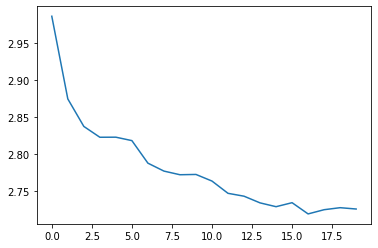

In [ ]:
loss_df = pd.read_csv('20epoch_drp.csv')
loss_df.iloc[:,1].plot()

In [ ]:
test['text'][35]

'continuous framework fairnessincreasingly discrimination algorithm perceived societal legal problem response number criterion implementing algorithmic fairness machine learning developed literature paper proposes continuous fairness algorithm cfa theta enables continuous interpolation different fairness definition specifically main contribution existing literature first approach allows decision maker continuously vary concept individual group fairness consequence algorithm enables decision maker adopt intermediate worldviews degree discrimination encoded algorithmic process adding nuance extreme case equal wae get wysiwyg proposed far literature second use optimal transport theory specifically concept barycenter maximize decision maker utility chosen fairness constraint third algorithm able handle case multi dimensional discrimination certain group ground criterion discus main example college admission credit application insurance contract map policy implication approach explicit form

In [ ]:
#from sklearn.metrics import classification_report
cnn_predictionsCS = []
cnn_predictionsPH = []
cnn_predictionsMA = []
cnn_predictionsST = []
cnn_predictionsQB = []
cnn_predictionsQF = []

with torch.no_grad():
    for index, row in test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['text'])
        probsCS, probsPH, probsMA, probsST, probsQB, probsQF = cnn_model(bow_vec)
        probsCS, probsPH, probsMA, probsST, probsQB, probsQF = cnn_model(bow_vec)
        _, predictedCS = torch.max(probsCS.data, 1)
        _, predictedPH = torch.max(probsPH.data, 1)
        _, predictedMA = torch.max(probsMA.data, 1)
        _, predictedST = torch.max(probsST.data, 1)
        _, predictedQB = torch.max(probsQB.data, 1)
        _, predictedQF = torch.max(probsQF.data, 1)
        cnn_predictionsCS.append(predictedCS.cpu().numpy()[0])
        cnn_predictionsPH.append(predictedPH.cpu().numpy()[0])
        cnn_predictionsMA.append(predictedMA.cpu().numpy()[0])
        cnn_predictionsST.append(predictedST.cpu().numpy()[0])
        cnn_predictionsQB.append(predictedQB.cpu().numpy()[0])
        cnn_predictionsQF.append(predictedQF.cpu().numpy()[0])
CS = pd.DataFrame(cnn_predictionsCS,columns =['Computer Science'])
PH = pd.DataFrame(cnn_predictionsPH,columns =['Physics'])
MA = pd.DataFrame(cnn_predictionsMA,columns =['Mathematics'])
ST = pd.DataFrame(cnn_predictionsST,columns =['Statistics'])
QB = pd.DataFrame(cnn_predictionsQB,columns =['Quantitative Biology'])
QF = pd.DataFrame(cnn_predictionsQF,columns =['Quantitative Finance'])

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/janataHackIndependenceDay')

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,0,0,0
1,20974,0,0,0,0,0,0
2,20975,0,0,0,0,0,0
3,20976,0,0,0,0,0,0
4,20977,0,0,0,0,0,0
...,...,...,...,...,...,...,...
8984,29957,0,0,0,0,0,0
8985,29958,0,0,0,0,0,0
8986,29959,0,0,0,0,0,0
8987,29960,0,0,0,0,0,0


In [ ]:
cnnoutput = submission['ID']

In [ ]:
cnnoutput = pd.concat([cnnoutput,CS,PH,MA,ST,QB,QF], axis=1)

In [ ]:
cnnoutput.to_csv('cnnoutput2_drp.csv',index=False)